In [265]:
%matplotlib inline

from IPython.display import Audio

from matplotlib import pyplot as plt
import numpy as np

from scipy.io import wavfile
from scipy import signal

import librosa
import librosa.display

from scipy.signal import fftconvolve

In [266]:
path_clean = 'sp03.wav'
Audio(path_clean)

In [267]:
rate, data = wavfile.read('sp03.wav')
duration = len(data)/rate
print("the sample rate is {} KHz".format(rate/1000))
print("The duration is {:.2f} s".format(duration))
print(len(data))

the sample rate is 16.0 KHz
The duration is 14.06 s
225023


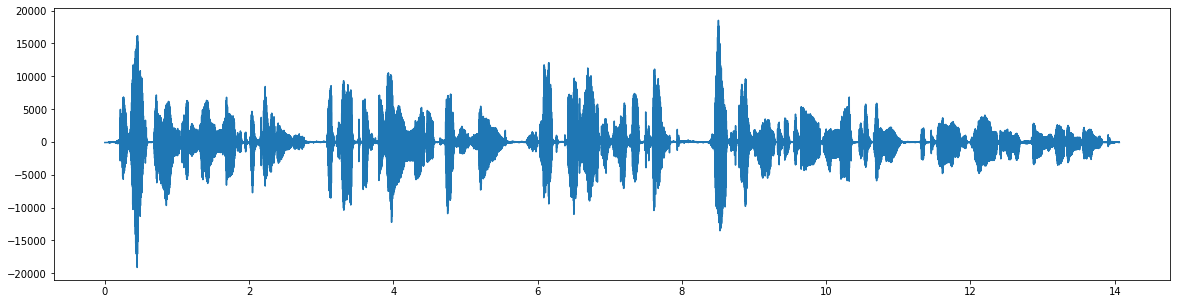

In [608]:
time = np.arange(len(data))/rate
plt.figure(figsize=[20, 5])
plt.plot(time, data)

# Using librosa.effects.split to remove silence

In [306]:
# split the signal into frames
data_ = np.array(data_, dtype='float32')
inds = librosa.effects.split(data_, top_db=30)
print(inds)
# for each frame we will take the stft


[[  1536  41984]
 [ 43008  80384]
 [ 81920 112128]
 [115712 155648]
 [157696 179712]
 [180224 196096]]


In [307]:
data_nonsilent = data
l = []
for i in inds:
    l.append( data_nonsilent[i[0]:i[1]] )
data_nonsilent = np.concatenate(l,axis=0)

225023 185856


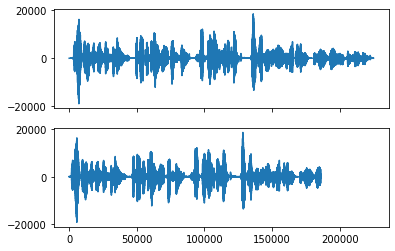

In [308]:
fig, ax = plt.subplots(2, 1, sharex=True)
ax[0].plot(data)
ax[1].plot(data_nonsilent)
print(len(data), len(data_nonsilent))


In [309]:
Audio(data=data_nonsilent, rate=rate)

# Lets do it without Librosa

# cut out the silent parts of the speech
To do this we will split up the audio into windows/frames and overlap the windows by 50%
for each window, we will get the RMS, which is defined by the following equation:
\begin{align}
\sqrt{ \frac{1}{N} \sum_n |x(n)|^2}
\end{align}

In [526]:
# calculate the energy of the signal, which is the total magnitude of the signal
# calculate this by splitting up the signal into overlapping frames
# this is called the overlap-add method
def get_energy(data, frame_length=882, hop_length=441):
    energy = np.array([
        sum(abs(data[i:i+frame_length]**2))
        for i in range(0, len(data), hop_length)
    ])
    return energy

In [527]:
def get_rms(data, frame_length=882, hop_length=441):
    '''
    convert samples to frames and get the rms for each frame
    '''
    energy = get_energy(data)
    rms = np.sqrt(energy/len(energy))
    return rms

# This is what the rms looks like across frame number

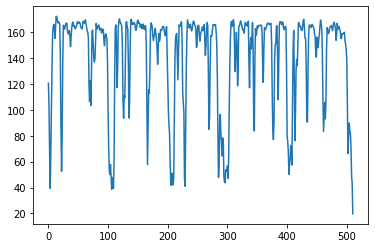

In [599]:
d = get_rms(data, frame_length=882, hop_length=441)
plt.plot(d)

# Now we can make a function to loop through each frame and collecting the frame index whose rms is below a given threshold. Then we can convert frames back to samples to visualize our signal 

In [624]:
def strip(x, thresh, frame_length=882, hop_length=441):

    # use overlap-add method to get the short-time energy
    # energy = get_energy(x, frame_length=frame_length, hop_length=hop_length)
    # Compute RMSE.
    # rms = np.sqrt((data**2)/len(data))**2
    # Compute RMSE.
    rms = get_rms(data, frame_length=882, hop_length=441)
    # get threshold crossings
    idx = []
    for frame_index in range(0, len(rms)):
        if rms[frame_index] < thresh:
            idx.append(frame_index)

        
    # Convert units of frames to samples using the hop_length/overlap
    start_sample_index = (np.asarray(idx) * hop_length).astype(int)
    
    return start_sample_index


In [625]:
inds = strip(data,80, frame_length=882, hop_length=441)


# now we can plot circles on the audio signal, which shows when the RMS fell below a threshold. As you can see these are doing an ok job of catching the silent periods

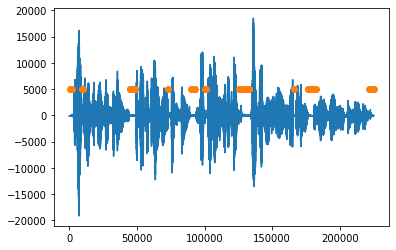

In [626]:
plt.plot(data)
plt.plot(inds, 5000*np.ones(len(inds)), 'o')

# Now lets collect only the datapoints in between two indices and concatenate to get our nonsilent signal

[   882   1323   1764   9702  10143  44541  44982  45423  45864  46305
  46746  47187  47628  48069  48510  73206  89964  90405  90846  91287
  91728  92169  92610 100548 100989 125685 126126 127890 128331 128772
 129213 129654 130095 130536 130977 131418 131859 132300 132741 133182
 166257 176400 176841 177282 177723 178164 178605 179046 179487 179928
 182133 221382 223587 224028 224469 224910]


Text(0.5, 0, 'Time (s)')

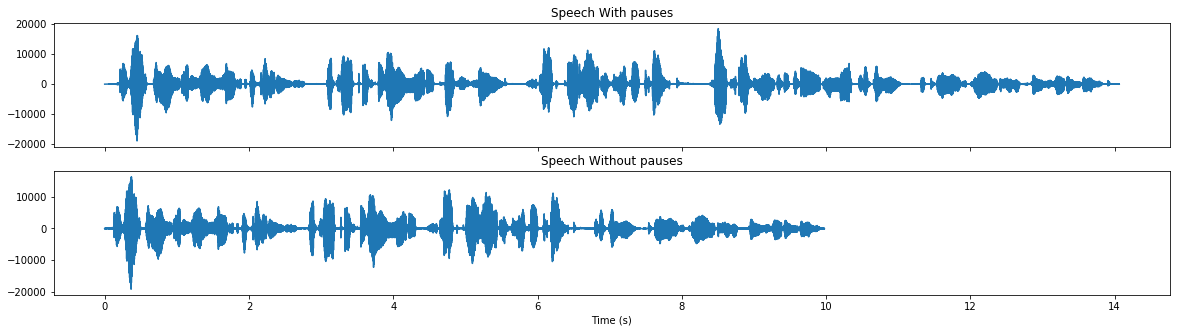

In [627]:

data_nonsilent = data
print(inds)
l = []
for i in range(0, len(inds)-1, 2):
    l.append( data_nonsilent[inds[i]:inds[i+1]])
short = np.concatenate(l,axis=None)

new_time = np.arange(len(short))/rate

fig, ax = plt.subplots(2, 1, sharex=True, figsize=[20, 5])
ax[0].plot(time, data)
ax[1].plot(new_time, l2)
ax[0].set_title('Speech With pauses')
ax[1].set_title('Speech Without pauses')
ax[1].set_xlabel('Time (s)')

# Viola!!!

In [628]:
f, t, signal_stft = signal.stft(data, rate, nperseg=882, noverlap=441) # data, nperseg, noverlap (50%)
Zsignal = librosa.power_to_db(np.abs(signal_stft**2), ref=np.max) # returns S_db ~= 10 * log10(S) - 10 * log10(ref)
print(Zsignal.shape)

(442, 512)


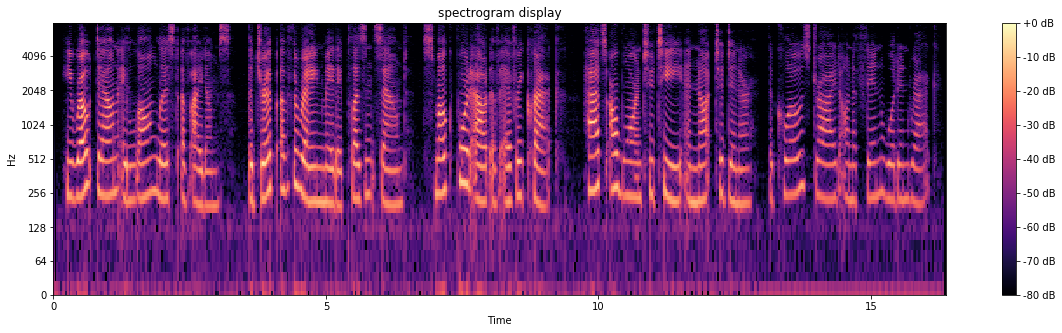

In [18]:
fig, ax= plt.subplots(figsize=[20, 5])
img = librosa.display.specshow(Zsignal,
                          sr=rate, y_axis='log', x_axis='time')
ax.set(title='spectrogram display')
fig.colorbar(img, ax=ax, format="%+2.f dB")